# <center>Practice 04. Logistic Regression</center>
## <center>Part 01. Titanic EDA</center>

Повторим разведочный анализ датасета пассажиров "Титаника", который можно скачать [тут](https://www.kaggle.com/competitions/titanic/data).

Описание датасета:
- **PassengerId** ––– id пассажира, можно взять за индекс
- **Survived** (целевой признак) ––– выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass** ––– класс билета (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex** ––– пол (female или male)	
- **Age** ––– возраст в годах
- **SibSp** –––	количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**	–––	количество детей и родителей на борту
- **Ticket** ––– номер билета	
- **Fare** ––– стоимость проезда пассажира	
- **Cabin** ––– номер каюты	
- **Embarked** ––– порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** выживет ли пассажир по его нецелевым признакам.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

df = pd.read_csv('../../data/titanic/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


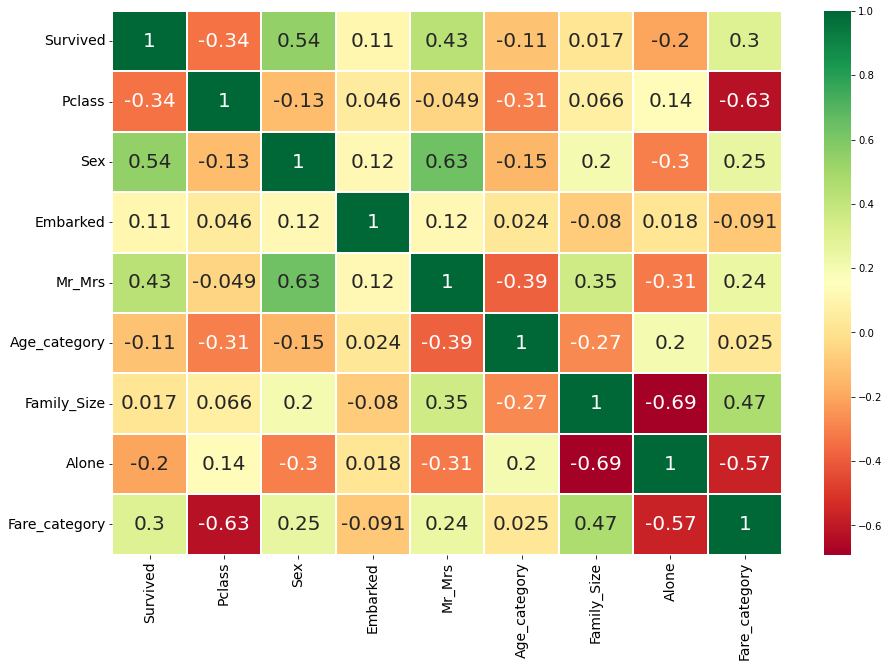

In [2]:
df['Mr_Mrs'] = 0
for i in df:
    df['Mr_Mrs']=df['Name'].str.extract('([A-Za-z]+)\.') # выделим обращения
df['Mr_Mrs'].\
replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],\
        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)
df.loc[(df['Mr_Mrs'] == 'Mr') & (df['Sex'] == 'female'), "Mr_Mrs"] = 'Mrs' # исправляем обращение к доктору женщине

df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Master'), 'Age'] = 5
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Miss'), 'Age'] = 22
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mr'), 'Age'] = 33
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mrs'), 'Age'] = 36
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Other'), 'Age'] = 46

df['Embarked'].fillna('S', inplace=True)

df['Age_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[df['Age'] <= 16, 'Age_category'] = 0  # далле разбиваем возраста на 5 категорий
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age_category'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age_category'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age_category'] = 3
df.loc[df['Age'] > 64, 'Age_category'] = 4

df['Family_Size'] = 0
df['Family_Size'] = df['Parch'] + df['SibSp']  # размер семьи
df['Alone'] = 0
df.loc[df['Family_Size'] == 0, 'Alone'] = 1  # путешествовал ли пассажир один

df['Fare_category'] = pd.qcut(df['Fare'], 5)
df['Fare_category'] = 0
df.loc[df['Fare'] <= 7.91, 'Fare_category'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare_category'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare_category'] = 2
df.loc[(df['Fare'] > 31) & (df['Fare'] <= 513), 'Fare_category'] = 3

df['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
df['Mr_Mrs'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)

df.drop(['Name', 'Age', 'Ticket', 'SibSp', 'Parch', 'Fare', 'Cabin', 'PassengerId'], axis=1, inplace=True)
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## <center>Part 02. Logistic Regression</center>

### RFE for feature selection

Если есть estimator, который позволяет раздать веса признакам, то recursive feature elimination (RFE) рассматривает рекурсивно все меньше и меньше признаков, убирая мало важные. В результате чего дойдет до желанного количества признаков.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Pclass","Sex","Embarked","Mr_Mrs","Age_category","Family_Size","Alone","Fare_category"] 
X_train = df[cols]
y_train = df['Survived']
# отберём с помощью RFE 5 признаков
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)
# выведем эти 5 признаков
print('Selected features: %s' % list(X_train.columns[rfe.support_]))

Selected features: ['Pclass', 'Sex', 'Mr_Mrs', 'Age_category', 'Alone']


RFECV позволяет выбрать оптимальное количество признаков кросс-валидацией

Optimal number of features: 6
Selected features: ['Pclass', 'Sex', 'Mr_Mrs', 'Age_category', 'Family_Size', 'Alone']


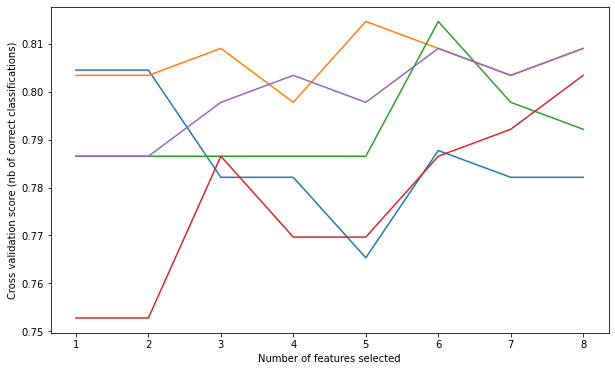

In [4]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

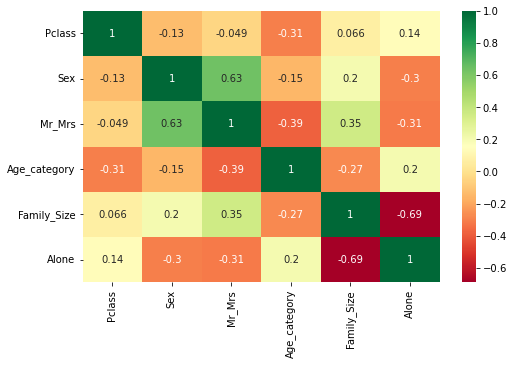

In [5]:
X_train = df[selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X_train.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Simple train/test split using train_test_split()

Обучим модель случайно разделим на test и train

Train/Test split results:
LogisticRegression accuracy is 0.810
LogisticRegression log_loss is 0.400
LogisticRegression auc is 0.897


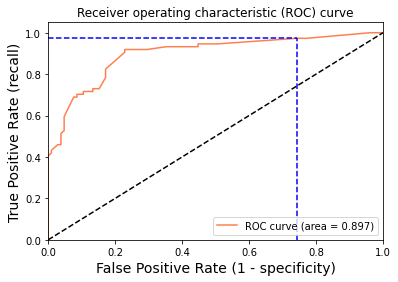

Using a threshold of 0.108 guarantees a sensitivity of 0.973 and a specificity of 0.257, i.e. a false positive rate of 74.29%.


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# Датасет с выбранными признаками
X = df[selected_features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # предсказываем вероятность по классам
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # индекс первого threshold с tpr > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### K-fold cross-validation using cross_val_score()

Обучаем модель с CV

In [7]:
logreg = LogisticRegression()
scores_accuracy = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=5, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.801
LogisticRegression average log_loss is 0.440
LogisticRegression average auc is 0.863


### GridSearchCV + multiple scorers

Обучаем модель с CV и ищем гиперпараметр C (чем меньше C тем больше регуляризация) по сетке. 

best params: LogisticRegression(C=0.10001)
best params: {'C': 0.10001}
best score: 0.8069612704789405


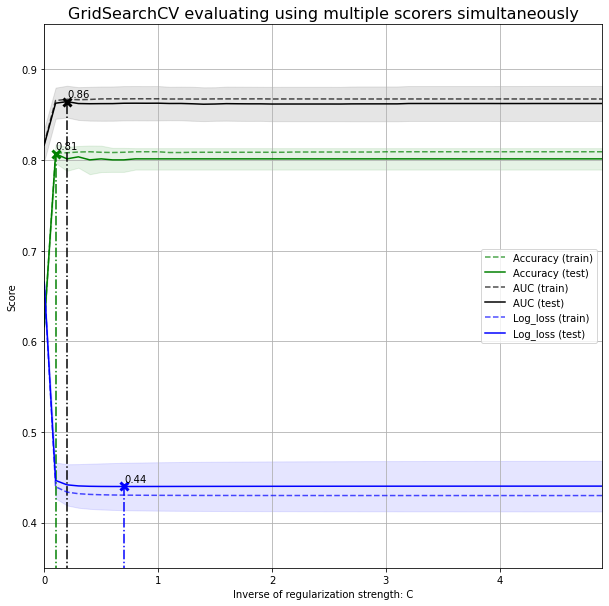

In [8]:
from sklearn.model_selection import GridSearchCV

X = df[selected_features]

param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.gca()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

### GridSearchCV + multiple scorers + RepeatedStratifiedKFold + pipeline

Поиск по сетке с помощью CV, повторяющийся несколько раз, с масштабированием и различными scorers. StratifiedKFold позволяет разделять выборки с сохранением соотношения объектов каждого класса (стратифицированно).

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

C = np.arange(1e-05, 5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#std_scale = StandardScaler(with_mean=False, with_std=False)
std_scale = StandardScaler()

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_


print('='*80)
print("best estimator: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*80)

best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('clf', LogisticRegression(C=0.40001000000000003))])
best params: {'clf__C': 0.40001000000000003}
best score: 0.8047266336074321


Визуализация CV

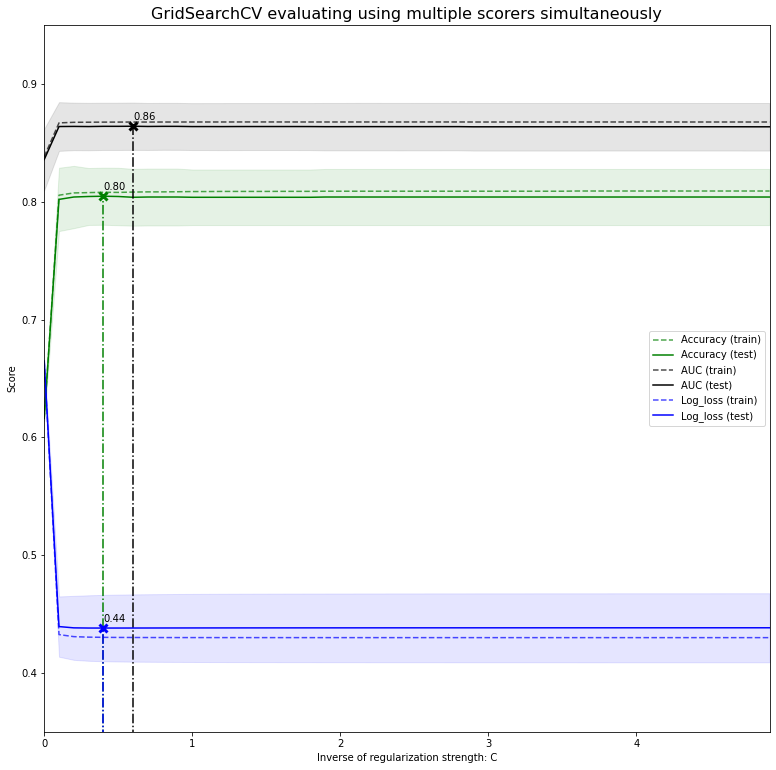

In [11]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, C.max()) 
ax.set_ylim(0.35, 0.95)

X_axis = np.array(results["param_clf__C"].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()